In [2]:
import sys
import os
if not any(path.endswith('textbook') for path in sys.path):
    sys.path.append(os.path.abspath('../../..'))
from textbook_utils import *

Code to create the mobility.csv file from the original
opportunity data, and basic analysis for the chapter.

In [3]:
from tqdm.notebook import trange, tqdm

In [4]:
from pyperclip import copy

In [5]:
from pathlib import Path

In [6]:
def subset_cov(cov):
    return cov.drop(columns=['czname', 'stateabbrv'])

def pop_as_int(cov):
    cov.loc[:, 'pop2000'] = pd.to_numeric(cov['pop2000'].str.replace(',', ''))
    return cov

In [7]:
# Online Data Table VIII
# Commuting Zone Characteristics
cov = (pd.read_stata('data/covariates.dta')
       .pipe(subset_cov)
       .pipe(pop_as_int)
      )
cov

,cz,pop2000,intersects_msa,cs_race_bla,...,cs_fam_wkidsinglemom,cs_divorced,cs_married,incgrowth0010
0,100.0,576081,1.0,2.08e-02,...,0.19,0.11,0.60,-2.28e-03
1,200.0,227816,1.0,1.98e-02,...,0.19,0.12,0.61,-2.15e-03
2,301.0,66708,0.0,1.46e-02,...,0.21,0.11,0.59,-3.71e-03
...,...,...,...,...,...,...,...,...,...
738,39302.0,166814,1.0,6.38e-03,...,0.19,0.10,0.54,-6.95e-03
739,39303.0,90478,0.0,6.85e-03,...,0.24,0.12,0.60,4.91e-05
740,39400.0,3775744,1.0,4.32e-02,...,0.19,0.12,0.54,-1.55e-03


In [8]:
def subset(df):
    return (
        df[['cz', 'czname', 'stateabbrv',  'e_rank_b_8082', 's_rank_8082']]
        .rename(columns={'e_rank_b_8082': 'aum',
                         's_rank_8082': 'rm'})
    )

In [9]:
def join_cov(df):
    return df.merge(cov, on='cz')

In [10]:
# Online Data Table V
# Intergenerational Mobility Estimates by Commuting Zone
df = (pd.read_stata('data/mobility.dta')
      .pipe(subset)
      .pipe(join_cov)
     )
df

,cz,czname,stateabbrv,aum,...,cs_fam_wkidsinglemom,cs_divorced,cs_married,incgrowth0010
0,100.0,Johnson City,TN,38.39,...,0.19,0.11,0.60,-2.28e-03
1,200.0,Morristown,TN,37.78,...,0.19,0.12,0.61,-2.15e-03
2,301.0,Middlesborough,TN,39.05,...,0.21,0.11,0.59,-3.71e-03
...,...,...,...,...,...,...,...,...,...
738,39302.0,Bellingham,WA,44.12,...,0.19,0.10,0.54,-6.95e-03
739,39303.0,Port Angeles,WA,41.41,...,0.24,0.12,0.60,4.91e-05
740,39400.0,Seattle,WA,43.20,...,0.19,0.12,0.54,-1.55e-03


In [33]:
df.to_csv('mobility.csv', index=False)

## setup

In [12]:
def resample(data): 
    X, y = data
    rows = np.random.randint(low=0, high=len(X), size=len(X))
    return X.iloc[rows], y.iloc[rows]

def bootstrap(data, statistic, replicates=10000):
    resample_estimates = [statistic(resample(data)) for _ in trange(replicates)]
    return np.array(resample_estimates)

In [13]:
def lin_reg_coeffs(data):
    X_train, y_train = data
    model = LinearRegression().fit(X_train, y_train)
    return model.coef_

In [14]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

In [15]:
def get_vars(df, X=['gini'], y='aum'):
    df = df[[*X, y]].dropna()
    return df[X], df[y]

In [16]:
one_each_category = [
#     'cs_race_bla',
    'frac_traveltime_lt15',
    'gini',
    'dropout_r',
    'rel_tot',
    'cs_fam_wkidsinglemom',
    'taxrate',
    'gradrate_r',
    'frac_worked1416',
    'cs_born_foreign',
]

small = [
    'frac_traveltime_lt15',
    'cs_fam_wkidsinglemom',
    'gradrate_r',
]

## small

In [17]:
X, y = df.pipe(get_vars, small)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.1, random_state=42)

In [18]:
model = LinearRegression().fit(X_train, y_train)
pred = model.predict(X_test)
mean_squared_error(y_test, model.predict(X_test))

6.658674

In [19]:
r_squared = model.score(X_train, y_train)
print(f'R^2: {r_squared:.2f}')

R^2: 0.72


In [20]:
model.coef_

array([ 18.8 , -61.  ,   1.19], dtype=float32)

In [21]:
thetas = bootstrap((X_train, y_train), lin_reg_coeffs)

  0%|          | 0/10000 [00:00<?, ?it/s]

In [22]:
thetas_ci = np.percentile(thetas, [2.5, 97.5], axis=0)
pd.DataFrame(thetas_ci.T,
             columns=['lower', 'upper'],
             index=small)

,lower,upper
frac_traveltime_lt15,15.12,22.23
cs_fam_wkidsinglemom,-67.81,-54.62
gradrate_r,-0.47,2.85


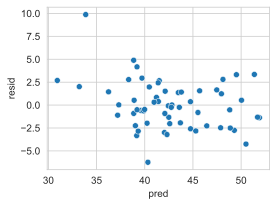

In [23]:
resid = (pd.DataFrame({'pred': pred, 'resid': y_test - pred})
         .reset_index(drop=True))
sns.scatterplot(data=resid, x='pred', y='resid');

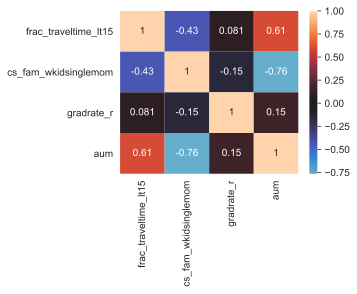

In [24]:
cols = [*small, 'aum']
sns.heatmap(df[cols].corr(), center=0, annot=True);

## one from each

In [25]:
X, y = df.pipe(get_vars, one_each_category)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.1, random_state=42)

In [26]:
model = LinearRegression().fit(X_train, y_train)
pred = model.predict(X_test)
mean_squared_error(y_test, model.predict(X_test))

6.3583207

In [27]:
r_squared = model.score(X_train, y_train)
print(f'R^2: {r_squared:.2f}')

R^2: 0.80


In [28]:
model.coef_

array([ 14.34,  -2.03, -34.78,   5.99, -41.48,  53.09,   0.4 , 465.64,
         6.03], dtype=float32)

In [29]:
thetas = bootstrap((X_train, y_train), lin_reg_coeffs)

  0%|          | 0/10000 [00:00<?, ?it/s]

In [30]:
thetas_ci = np.percentile(thetas, [2.5, 97.5], axis=0)
display_df(pd.DataFrame(thetas_ci.T,
                        columns=['lower', 'upper'],
                        index=one_each_category),
           rows=9)

,lower,upper
frac_traveltime_lt15,11.59,17.25
gini,-6.00,3.27
dropout_r,-51.48,-17.97
rel_tot,4.06,8.01
cs_fam_wkidsinglemom,-49.36,-34.25
taxrate,7.32,102.83
gradrate_r,-1.42,2.14
frac_worked1416,211.91,728.30
cs_born_foreign,-2.84,12.24


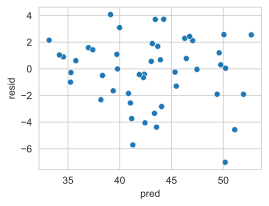

In [31]:
resid = (pd.DataFrame({'pred': pred, 'resid': y_test - pred})
         .reset_index(drop=True))
sns.scatterplot(data=resid, x='pred', y='resid');

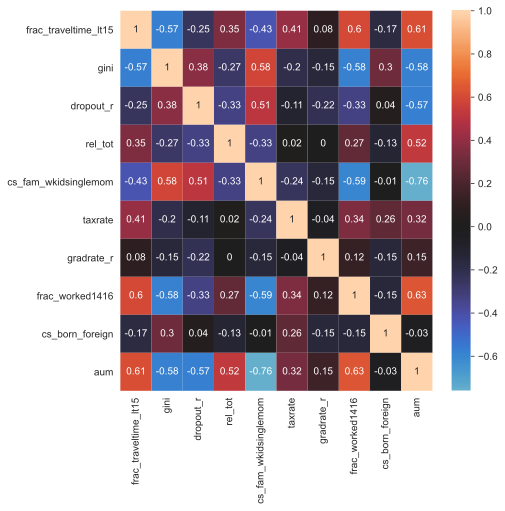

In [32]:
cols = [*one_each_category, 'aum']
plt.figure(figsize=(7, 7))
sns.heatmap(df[cols].corr().round(2), center=0, annot=True);